# SKEMPI 2.0 benchmark: data filtraton and processing

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import math

In [27]:
# Add a timestamp to the saved csv in the end

from datetime import datetime
time_stamp = datetime.today().strftime('%Y-%m-%d')

In [2]:
# Load the dataset

skempi2 = pd.read_csv('skempi_v2.csv', sep=';') # 7085 rows

In [3]:
skempi2['N_mut'] = skempi2['Mutation(s)_PDB'].str.split(',').str.len()
#skempi2['N_mut'] = skempi2['N_mut'].apply(lambda x: '3+' if x >= 3 else x)
#skempi2['N_mut'] = skempi2['N_mut'].apply(str)

In [4]:
skempi2['Entry'] = skempi2.index + 1

In [5]:
original_skempi_len = len(skempi2)

In [6]:
# Get a list of uniqie PDB IDs in the dataset 

pdb_list = skempi2['#Pdb'].str.split("_").str[0].unique().tolist()
print(f"{len(pdb_list)} unique PDB IDs") # 345

345 unique PDB IDs


Uncomment to generate a text file with PDB ID list -- required for RCSB batch download script (https://www.rcsb.org/docs/programmatic-access/batch-downloads-with-shell-script):


In [7]:
# with open('pdb_list.txt', 'w') as f:
#     for pdb in pdb_list:
#         f.write(f"{pdb},")

In [8]:
# Get a separate PDB ID column

skempi2['PDB_ID'] = skempi2['#Pdb'].str.split('_').str[0]

## Step 1: Dropping and counting duplicates

In [9]:
## Only works if 'Entry' field is not added, obviously.
## Still highlights the fact that thereare 11 full duplicates in the database.

# Possibly just a mistake? I checked row by row, field by field, and didn't see anything.

print(f"{len(skempi2.loc[skempi2.duplicated()])} entries are duplicated. {len(skempi2.loc[skempi2.duplicated()].loc[skempi2['SKEMPI version']==2])} of them are added in SKEMPI version 2.0")
print("Dropping the duplicates.")

skempi2.drop_duplicates(inplace=True, ignore_index=True) # 7074 rows (11 duplicated, 10 from SKEMPI 2.0)

print(f"New dataset size: {len(skempi2)}")

0 entries are duplicated. 0 of them are added in SKEMPI version 2.0
Dropping the duplicates.
New dataset size: 7085


## Step 2: Counting cases with unprecise binding affinity values

In [10]:
# Counts for cases with binding affinity values defined as smaller/larger then a certain detection threshold

out_of_range_total = skempi2.loc[(skempi2['Affinity_mut (M)'].str.startswith(('<',
            '>')))|(skempi2['Affinity_wt (M)'].str.startswith(('<', '>')))]

out_of_range_wt_mut = skempi2.loc[(skempi2['Affinity_mut (M)'].str.startswith(('<',
            '>')))&(skempi2['Affinity_wt (M)'].str.startswith(('<', '>')))]

out_of_range_wt = skempi2.loc[(skempi2['Affinity_wt (M)'].str.startswith(('<', '>')))&(~skempi2['Affinity_mut (M)'].str.startswith(('<', '>')))]

out_of_range_mut = skempi2.loc[(skempi2['Affinity_mut (M)'].str.startswith(('<', '>')))&(~skempi2['Affinity_wt (M)'].str.startswith(('<', '>')))]

print(f"Total cases with wild-type and/or mutant complex binding affinity out of detection range: ")
print(f"{len(out_of_range_total)} ({round(len(out_of_range_total)/original_skempi_len*100, 2)}% of the dataset), {len(out_of_range_total['PDB_ID'].unique())} unique PDB structures \n") # 186, 2.63%, 47 

print(f"Total cases with binding affinities of BOTH WILD TYPE AND MUTANT complexes out of detection range: ")
print(f"{len(out_of_range_wt_mut)}, {len(out_of_range_wt_mut['PDB_ID'].unique())} unique PDB structures ({', '.join(out_of_range_wt_mut['PDB_ID'].unique().tolist())}), {len(out_of_range_wt_mut['Method'].unique())} uniqie methods ({', '.join(out_of_range_wt_mut['Method'].unique())}) \n") # 14, 2 (4I77, 1CZ8), SPR

print(f"Total cases with binding affinities of WILD TYPE complexes out of detection range: ")
print(f"{len(out_of_range_wt)}, {len(out_of_range_wt['PDB_ID'].unique())} unique PDB structures ({', '.join(out_of_range_wt['PDB_ID'].unique().tolist())}), {len(out_of_range_wt['Method'].unique())} uniqie methods ({', '.join(out_of_range_wt['Method'].unique())}) \n") # 27, 2 (4I77, 1CZ8), SPR

print(f"Total cases with binding affinities of MUTANT complexes out of detection range: ")
print(f"{len(out_of_range_mut)}, {len(out_of_range_mut['PDB_ID'].unique())} unique PDB structures ({', '.join(out_of_range_mut['PDB_ID'].unique().tolist())}), {len(out_of_range_mut['Method'].unique())} uniqie methods ({', '.join(out_of_range_mut['Method'].unique())})") # 145, 45

print("\nThose values are parsed by SKEMPI itself as a threshold value, e. g. '>5E-05' becomes 0.00005")

Total cases with wild-type and/or mutant complex binding affinity out of detection range: 
186 (2.63% of the dataset), 47 unique PDB structures 

Total cases with binding affinities of BOTH WILD TYPE AND MUTANT complexes out of detection range: 
14, 2 unique PDB structures (4I77, 1CZ8), 1 uniqie methods (SPR) 

Total cases with binding affinities of WILD TYPE complexes out of detection range: 
27, 2 unique PDB structures (4I77, 1CZ8), 1 uniqie methods (SPR) 

Total cases with binding affinities of MUTANT complexes out of detection range: 
145, 45 unique PDB structures (1SBB, 1JCK, 1AK4, 1AHW, 1VFB, 2WPT, 2JEL, 2OOB, 2A9K, 1REW, 1HE8, 3BN9, 2FTL, 1A22, 1FCC, 3HFM, 1SMF, 1OGA, 2P5E, 2PYE, 3QDJ, 1MI5, 2AK4, 1AO7, 3G6D, 3Q8D, 4B0M, 1BJ1, 1MHP, 1MLC, 3SE3, 3SE4, 4KRL, 4KRO, 4KRP, 4OZG, 4PWX, 2C5D, 4RS1, 1C1Y, 4G0N, 1LFD, 5XCO, 2KSO, 3QIB), 12 uniqie methods (SE, SPR, IASP, FL, SFFL, CSPRIA, ITC, IARA, IAFL, ELISA, SP, KinExA)

Those values are parsed by SKEMPI itself as a threshold value, e

In [11]:
skempi2['Kd_val_type'] = 'Regular'

skempi2.loc[skempi2['Affinity_mut (M)'].str.startswith('<'),'Kd_val_type'] = 'MUT stronger than threshold'
skempi2.loc[skempi2['Affinity_mut (M)'].str.startswith('>'), 'Kd_val_type'] = 'MUT weaker than threshold'

skempi2.loc[skempi2['Affinity_wt (M)'].str.startswith('<'),'Kd_val_type'] = 'WT stronger than threshold'
skempi2.loc[skempi2['Affinity_wt (M)'].str.startswith('>'), 'Kd_val_type'] = 'WT weaker than threshold'

skempi2.loc[(skempi2['Affinity_mut (M)'].str.startswith(('<',
            '>')))&(skempi2['Affinity_wt (M)'].str.startswith(('<', '>'))), 'Kd_val_type'] = 'Both WT and MUT are out of range'

#### **To Do:** separate "smaller than" from "bigger than" in a meaning full way (e.g. "very strong interaction" vs "very weak")

## Step 2: Calculating binding dG of the wild type and mutant complexes from binding affinities, calculating binding ddG, filtering out and solving ddG_bind is NaN cases

In [12]:
# Using ΔG = R*T*ln(Kd)

skempi2['dG_bind_WT'] =  0.001987204 * skempi2['Temperature'].str.extract('(\d+)'
                        ).values.astype(float).reshape(-1) * np.log(skempi2['Affinity_wt_parsed'].values)
skempi2['dG_bind_MUT'] = 0.001987204 * skempi2['Temperature'].str.extract('(\d+)'
                        ).values.astype(float).reshape(-1) * np.log(skempi2['Affinity_mut_parsed'].values)
skempi2['ddG_bind'] = skempi2['dG_bind_MUT'].values - skempi2['dG_bind_WT'].values

In [13]:
ddG_bind_na = skempi2.loc[skempi2['ddG_bind'].isna()]

print(f"Total cases with binding ddG being NaN: {len(ddG_bind_na)} ({round(len(ddG_bind_na)/original_skempi_len*100, 2)}% of the dataset), {len(ddG_bind_na['#Pdb'].str[0:4].unique())} unique PDB structures)")
print(f"From them:")
print(f"{len(skempi2.loc[skempi2['Temperature'].isna()])} do not have a temperature value")
print(f"{len(skempi2.loc[skempi2['Affinity_mut (M)'].isin(['n.b', 'n.b.'])])} are classified as 'no interaction' for mutant")
print(f"{len(skempi2.loc[skempi2['Affinity_wt (M)'].isin(['n.b', 'n.b.'])])} are classified as 'no interaction' for wild type")
print(f"{len(skempi2.loc[skempi2['Affinity_mut (M)']=='unf'])} are classified as 'unfolded mutant'")

print("\nSanity check: ")
print(f"{len(skempi2.loc[skempi2['Temperature'].isna()])} + {len(skempi2.loc[skempi2['Affinity_mut (M)'].isin(['n.b', 'n.b.'])])} + {len(skempi2.loc[skempi2['Affinity_wt (M)'].isin(['n.b', 'n.b.'])])} + {len(skempi2.loc[skempi2['Affinity_mut (M)']=='unf'])} = {len(skempi2.loc[skempi2['Temperature'].isna()]) + len(skempi2.loc[skempi2['Affinity_mut (M)'].isin(['n.b', 'n.b.'])]) + len(skempi2.loc[skempi2['Affinity_wt (M)'].isin(['n.b', 'n.b.'])]) + len(skempi2.loc[skempi2['Affinity_mut (M)']=='unf'])}")

Total cases with binding ddG being NaN: 291 (4.11% of the dataset), 76 unique PDB structures)
From them:
4 do not have a temperature value
278 are classified as 'no interaction' for mutant
2 are classified as 'no interaction' for wild type
7 are classified as 'unfolded mutant'

Sanity check: 
4 + 278 + 2 + 7 = 291


In [14]:
# If K_D is not a specific value, assign it to be NaN
# This is needed for a proper mean values calculation.
# If one sourse gives a specific value, and another 
# "out of detection limit" value, we want mean value
# to ignore the latter.
skempi2.loc[skempi2['Kd_val_type']!='Regular', 'ddG_bind'] = np.nan

Keeping the cases with no dG values, dropping the cases without temperature values.

In [15]:
# Drop cases without temperature values -- we cannot calculate binding ddGs for that

skempi2 = skempi2.loc[~skempi2['Temperature'].isna()].reset_index(drop=True) # 7070

In [16]:
# To keep track of cases without a value for binding affinities -- we might assign them new values for comparison with predictors

skempi2.loc[skempi2['Affinity_mut (M)'].isin(['n.b', 'n.b.']), 'Kd_val_type'] = 'no binding MUT'
skempi2.loc[skempi2['Affinity_wt (M)'].isin(['n.b', 'n.b.']), 'Kd_val_type'] = 'no binding WT'
skempi2.loc[skempi2['Affinity_mut (M)']=='unf', 'Kd_val_type'] = 'unfolded MUT'

## Step 3: Filtering out values with disagreeing measurements by multiple methods, calculating the average

#### **To Do:** analysis of errors in dG_mut, dG_wt and ddG

In [17]:
# Calculate 'mean_experimental_value' and 'std_experimental_value'
# for each unique mutant, based only on the valid numerical measurements.

# Make sure mutations for multimutants are ordered the same
skempi2['Mutation(s)_PDB'] = skempi2['Mutation(s)_PDB'].apply(lambda x: ','.join(sorted(x.split(','))))

df = skempi2.copy()
df_copy = df.copy()

# Group and apply both aggregation functions

aggregation_functions = [
        ('ddG_bind_mean', 'mean'),
        ('ddG_bind_std', 'std')
    ]

df_stats = (
    df_copy
    .groupby(['#Pdb', 'Mutation(s)_PDB'])
    ['ddG_bind']
    .agg(aggregation_functions)
    .reset_index()
)

# Create the list of averaged entries

# Convert the 'Entry' column to string type to ensure concatenation works properly.
df_copy['Entry_str'] = df_copy['Entry'].astype(str)

# Group by mutant identifiers and aggregate the 'Entry_str' using a lambda function
# to join the strings with a comma and space.
df_entry_list = (
    df_copy
    .groupby(['#Pdb', 'Mutation(s)_PDB'])
    ['Entry_str']
    # Aggregation function: joins all entry strings for the group
    .agg(lambda x: ', '.join(x))
    .rename('Averaged_Entry_List')
    .reset_index()
)

df_merged_stats = pd.merge(
    df_copy,
    df_stats,
    on=['#Pdb', 'Mutation(s)_PDB'],
    how='left'
)


# Merge the results back into the original DataFrame
df_merged = pd.merge(
    df_merged_stats,
    df_entry_list,
    on=['#Pdb', 'Mutation(s)_PDB'],
    how='left'
)

# Make sure original entry numbers are ordered the same in all cases
df_merged['Averaged_Entry_List'] = df_merged['Averaged_Entry_List'].apply(lambda x: ','.join(sorted(x.split(','))))

# To keep track of cases measured with multiple methods
df_merged['multiple_measurements'] = False
df_merged.loc[~df_merged['ddG_bind_std'].isna(), 'multiple_measurements'] = True

In [18]:
# Get the final subset by keeping only proper ddG value entries
# with std smaller than 1.
skempiMAX_duplicates = df_merged.loc[(df_merged['Kd_val_type']=='Regular'
                                     )&((df_merged['ddG_bind_std']<1)|(df_merged['ddG_bind_std'].isna()))]

# Drop identical rows
skempiMAX = skempiMAX_duplicates.drop_duplicates(subset=['#Pdb', 'Mutation(s)_PDB', 'Averaged_Entry_List']).copy()

In [19]:
mult = df_merged.loc[df_merged['multiple_measurements']].copy()
mult_std_1 = mult.loc[mult['ddG_bind_std']>1]
mult_avg = skempiMAX.loc[skempiMAX['Averaged_Entry_List'].str.split(',').str.len()>1].copy()


print("Total measures with multiple methods:", len(mult), '(', 
     round(len(mult)/original_skempi_len*100, 2), '% of the dataset),', 
      len(mult['PDB_ID'].unique()), 'unique PDB structures')

print("Total cases measured with multiple methods:", len(mult_avg), '(',
      round(len(mult_avg)/original_skempi_len*100, 2), '% of the dataset),',
      len(mult_avg['PDB_ID'].unique()), "unique PDB structures")

print("Number of cases measured with multiple methods with stds > 1:", len(mult_std_1),
      '(', round(len(mult_std_1)/original_skempi_len*100, 2), '% of the dataset),',
      len(mult_std_1['PDB_ID'].unique()), "unique PDB structures,",
      len(mult_std_1.groupby(['PDB_ID', 'Mutation(s)_PDB']).count()), "cases")

print(f"Final dataset size: {len(skempiMAX)} cases")

# Add chain identifiers as a separate column -- needed for mut- and resfiles naming

skempiMAX['LChains'] = skempiMAX['#Pdb'].str.split("_").str[1]
skempiMAX['RChains'] = skempiMAX['#Pdb'].str.split("_").str[2]
skempiMAX["Chains"] = skempiMAX["LChains"].astype(str) + skempiMAX["RChains"].astype(str)

# # Add index as a column and form a case ID from the number and the PDB
# skempiMAX['index'] = skempiMAX.index.tolist()
# skempiMAX['case_ID'] = skempiMAX['index'].astype('str') + '_' + skempiMAX['PDB_ID']

Total measures with multiple methods: 1463 ( 20.65 % of the dataset), 66 unique PDB structures
Total cases measured with multiple methods: 578 ( 8.16 % of the dataset), 69 unique PDB structures
Number of cases measured with multiple methods with stds > 1: 49 ( 0.69 % of the dataset), 12 unique PDB structures, 18 cases
Final dataset size: 5723 cases


Total measures with multiple methods: 1481 (20.9% of the dataset), 68 unique PDB structures <br>
Total cases measured with multiple methods: 608 (8.58% of the dataset), 67 unique PDB structures <br>
Number of cases measured with multiple methods with stds > 1: 53 (0.75% of the dataset), 13 unique PDB structures <br>
Final dataset size: 6171 cases

## Step 4: Restructuring the dataframe and saving the final version

In [20]:
# Reorder and rename the columns

skempiMAX = skempiMAX[['Entry', 'PDB_ID', '#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned',
       'iMutation_Location(s)', 'Hold_out_type', 'Hold_out_proteins',
       'Affinity_mut (M)', 'Affinity_mut_parsed', 'Affinity_wt (M)',
       'Affinity_wt_parsed', 'Reference', 'Protein 1', 'Protein 2',
       'Temperature', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed',
       'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))',
       'koff_mut_parsed', 'koff_wt (s^(-1))', 'koff_wt_parsed',
       'dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))',
       'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes',
       'Method', 'SKEMPI version', 'Kd_val_type', 'multiple_measurements', 'dG_bind_WT',
       'dG_bind_MUT', 'ddG_bind_mean', 'LChains', 'RChains', 'Chains']]

skempiMAX.rename(columns={"ddG_bind_mean": "ddG_bind"}, inplace=True)

In [21]:
van_der_waals_volumes={'G': 48,
 'A': 67,
 'S': 73,
 'C': 86,
 'T': 93,
 'P': 90,
 'D': 91,
 'N': 96,
 'V': 105,
 'E': 109,
 'Q': 114,
 'I': 124,
 'L': 124,
 'M': 124,
 'H': 118,
 'K': 135,
 'F': 135,
 'R': 148,
 'Y': 141,
 'W': 163}

stl_list = list()
for index, row in skempiMAX.iterrows():
    muts = row['Mutation(s)_PDB'].split(',')
    stl = True
    for mut in muts:
        wt = mut[0]
        sub = mut[-1]
        if van_der_waals_volumes[sub]<=van_der_waals_volumes[wt]:
            stl = False
    stl_list.append(stl)
skempiMAX['small-to-large'] = stl_list

In [22]:
infc_res = ['W', 'F', 'Y', 'C', 'I', 'L', 'M', 'V', 'H', 'R']

infc_tf = list()
for index, row in skempiMAX.iterrows():
    muts = row['Mutation(s)_PDB'].split(',')
    case_types = list()
    for mut in muts:
        wt = mut[0]
        sub = mut[-1]
        wt_infc = 'non-infc'
        sub_infc = 'non-infc'
        if wt in infc_res:
            wt_infc = 'infc'
        if sub in infc_res:
            sub_infc = 'infc'
            
        aa_infc = f'{wt_infc} to {sub_infc}'

        case_types.append(aa_infc)
        
    if len(set(case_types))>1 and len(muts)>1:
        aa_infc = 'mixed'
            
    infc_tf.append(aa_infc)
skempiMAX['type_of_change_infc'] = infc_tf

In [23]:
aa_types = {'hydrophobic': ['A', 'V', 'L', 'I', 'M', 'F', 'Y', 'W'],
             'polar': ['S', 'T', 'N', 'Q'],
             'positive': ['R', 'H', 'K'],
             'negative': ['D', 'E'],
             'special': ['C', 'G', 'P']}


mut_type_list = list()
for index, row in skempiMAX.iterrows():
    muts = row['Mutation(s)_PDB'].split(',')
    case_types = list()
    for mut in muts:
        wt = mut[0]
        sub = mut[-1]
        for aa_lst in aa_types.items():
            if wt in aa_lst[1]:
                wt_type = aa_lst[0]
            if sub in aa_lst[1]:
                sub_type = aa_lst[0]

        if wt_type == sub_type:
            mut_type = 'same type'
        # elif sub_type == 'hydrophobic':
        #     mut_type = 'any to hydrophobic'
        # elif sub_type == 'special':
        #     mut_type = 'any to special'
        # elif wt_type == 'special':
        #     mut_type = 'special to any'
        else:
             mut_type = f'{wt_type} to {sub_type}'
        
        case_types.append(mut_type)
        
    if len(set(case_types))>1 and len(muts)>1:
        mut_type = 'mixed'

    mut_type_list.append(mut_type)
    
skempiMAX['type_of_change_aa'] = mut_type_list

In [24]:
skempiMAX['interaction_strength'] = 'None'
skempiMAX.loc[skempiMAX['Affinity_wt_parsed']>=10**(-3), 'interaction_strength'] = 'ultra-weak'
skempiMAX.loc[(skempiMAX['Affinity_wt_parsed']<10**(-3))&(skempiMAX['Affinity_wt_parsed']>=10**(-6)), 'interaction_strength'] = 'weak'
skempiMAX.loc[(skempiMAX['Affinity_wt_parsed']<10**(-6))&(skempiMAX['Affinity_wt_parsed']>=10**(-9)), 'interaction_strength'] = 'moderate'
skempiMAX.loc[skempiMAX['Affinity_wt_parsed']<10**(-9), 'interaction_strength'] = 'strong'

print('Strong interaction Hold out type distributions: ')
print(skempiMAX.loc[skempiMAX['interaction_strength']=='strong']['Hold_out_type'].value_counts())
print('Moderate interaction Hold out type distributions: ')
print(skempiMAX.loc[skempiMAX['interaction_strength']=='moderate']['Hold_out_type'].value_counts())
print('Weak interaction Hold out type distributions: ')
print(skempiMAX.loc[skempiMAX['interaction_strength']=='weak']['Hold_out_type'].value_counts())

for hot in ['Pr/PI', 'TCR/pMHC', 'AB/AG']:
    print(hot, 'K_D wild type')
    print('Median', skempiMAX.loc[skempiMAX['Hold_out_type']==hot]['Affinity_wt_parsed'].median())
    print('Min', skempiMAX.loc[skempiMAX['Hold_out_type']==hot]['Affinity_wt_parsed'].min())
    print('Max', skempiMAX.loc[skempiMAX['Hold_out_type']==hot]['Affinity_wt_parsed'].max())

Strong interaction Hold out type distributions: 
Hold_out_type
Pr/PI          1177
AB/AG           238
AB/AG,Pr/PI      60
TCR/pMHC         10
Name: count, dtype: int64
Moderate interaction Hold out type distributions: 
Hold_out_type
AB/AG       637
TCR/pMHC     74
Pr/PI        65
Name: count, dtype: int64
Weak interaction Hold out type distributions: 
Hold_out_type
TCR/pMHC    466
Pr/PI         8
AB/AG         5
Name: count, dtype: int64
Pr/PI K_D wild type
Median 2.72e-11
Min 5e-14
Max 6.67e-05
TCR/pMHC K_D wild type
Median 5.2e-06
Min 4.77e-11
Max 0.00014
AB/AG K_D wild type
Median 3e-09
Min 3.72e-12
Max 5e-06


In [25]:
# Save the new filtered dataframe

skempiMAX.to_csv(f'skempiMAX-{time_stamp}.csv', index=False)

## Bits and pieces (ignore)

In [ ]:
skempiMAX

In [63]:
import math

for i in [-10, -6, -5, -2, -1, 0, 1, 2, 5, 6, 10]:
    print('ddG_bind', i, 'Kd_mut/Kd_wt', math.exp(i/(0.001987*298)))
    
for i in np.arange(-10.0, 10.0, 1.36):
    print('dG_bind', i, 'Kd', math.exp(i/(0.001987*298)))

ddG_bind -10 Kd_mut/Kd_wt 4.629196545585792e-08
ddG_bind -6 Kd_mut/Kd_wt 3.97469100725155e-05
ddG_bind -5 Kd_mut/Kd_wt 0.00021515567725685956
ddG_bind -2 Kd_mut/Kd_wt 0.03412723665447046
ddG_bind -1 Kd_mut/Kd_wt 0.18473558578268146
ddG_bind 0 Kd_mut/Kd_wt 1.0
ddG_bind 1 Kd_mut/Kd_wt 5.413142225755985
ddG_bind 2 Kd_mut/Kd_wt 29.302108756262456
ddG_bind 5 Kd_mut/Kd_wt 4647.797412318192
ddG_bind 6 Kd_mut/Kd_wt 25159.18842937901
ddG_bind 10 Kd_mut/Kd_wt 21602020.785951685
dG_bind -10.0 Kd 4.629196545585792e-08
dG_bind -8.64 Kd 4.602532416454176e-07
dG_bind -7.280000000000001 Kd 4.576021872458855e-06
dG_bind -5.920000000000002 Kd 4.54966402895086e-05
dG_bind -4.560000000000002 Kd 0.0004523458006376798
dG_bind -3.200000000000003 Kd 0.004497402930249506
dG_bind -1.8400000000000034 Kd 0.04471497931118847
dG_bind -0.480000000000004 Kd 0.44457421445427164
dG_bind 0.8799999999999955 Kd 4.420134711058182
dG_bind 2.239999999999995 Kd 43.94674776152818
dG_bind 3.5999999999999943 Kd 436.9361490236169

In [21]:
import seaborn as sns

<Axes: xlabel='ddG_bind_std', ylabel='Count'>

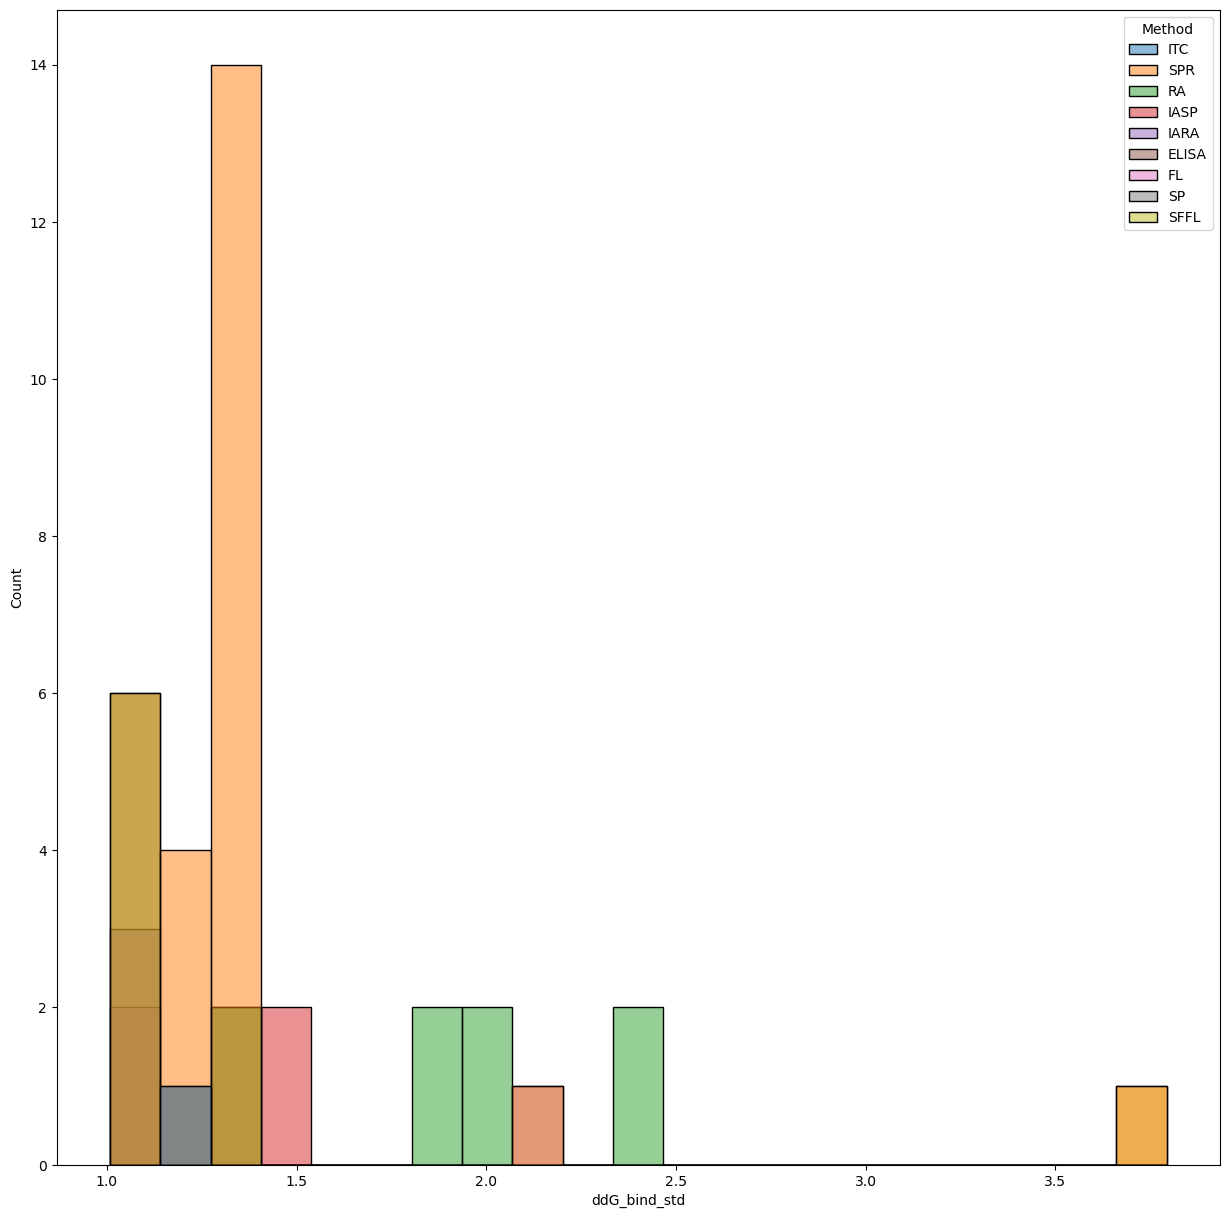

In [31]:
fig = plt.figure(figsize=(15, 15))
#sns.histplot(data=S4169_merged, x="ddG_bind_rev", hue="Method")
sns.histplot(x=skempi2_mm.loc[skempi2_mm['ddG_bind_std']>1]["ddG_bind_std"],
             hue=skempi2_mm.loc[skempi2_mm['ddG_bind_std']>1]["Method"])

<Axes: xlabel='Method', ylabel='count'>

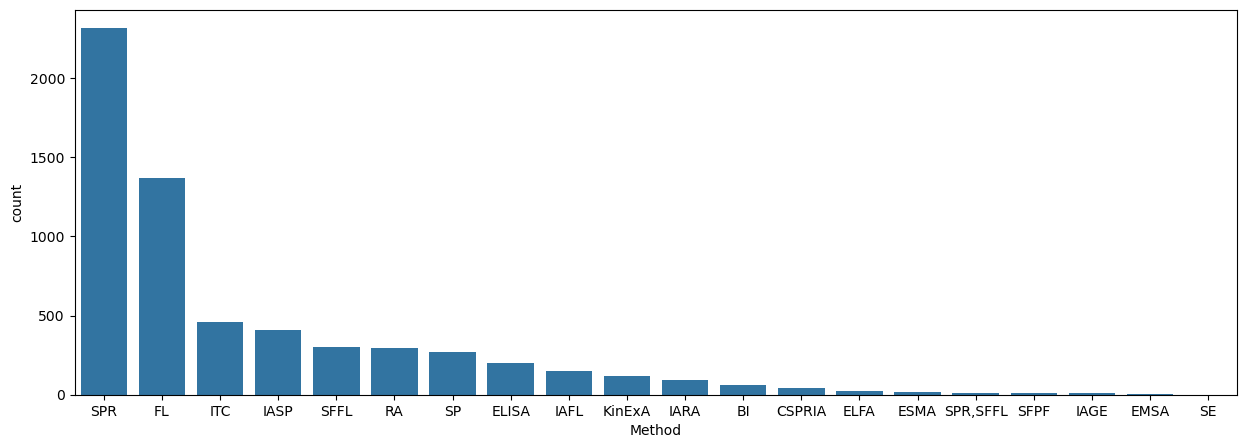

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=skempi2_avg, x='Method', order=skempi2_avg['Method'].value_counts().index, ax=ax)

<Axes: xlabel='Method', ylabel='count'>

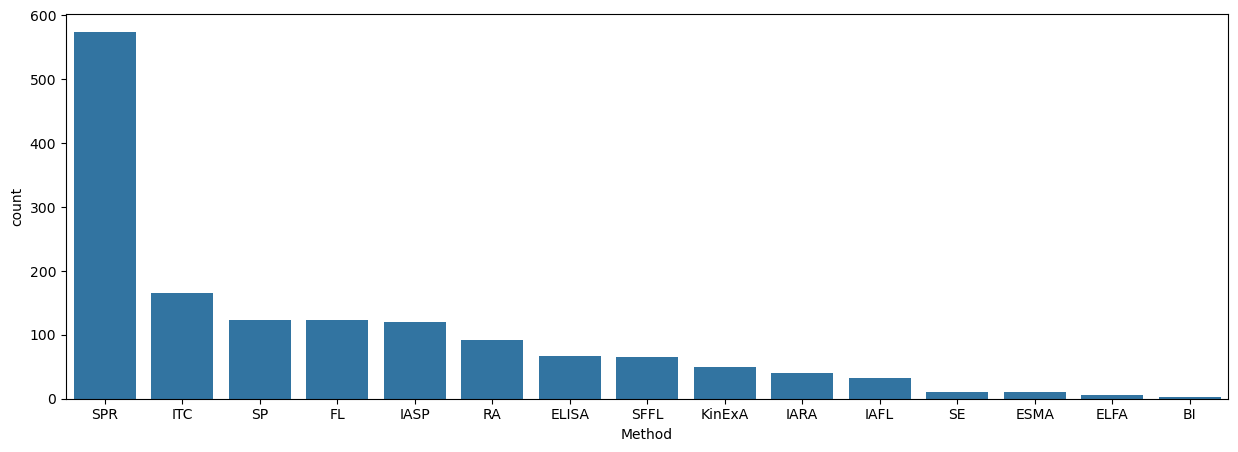

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=skempi2_mm, x='Method', order=skempi2_mm['Method'].value_counts().index, ax=ax)

<Axes: xlabel='Method', ylabel='ddG_bind_std'>

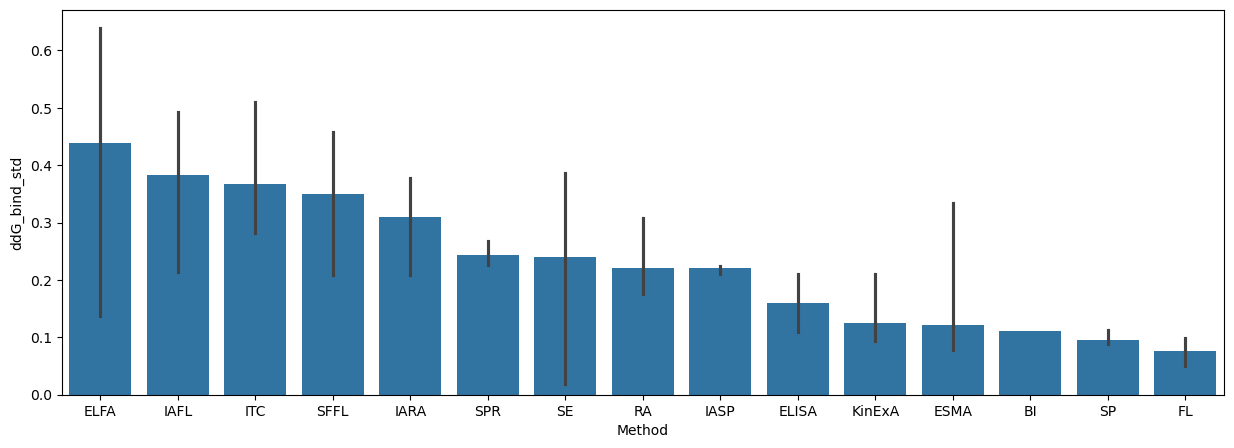

In [67]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=skempi2_mm, x='Method', y='ddG_bind_std',
            order=skempi2_mm[['Method', 'ddG_bind_std']].groupby(['Method']).median().sort_values(by=['ddG_bind_std'], ascending=False).index,
            ax=ax,
            estimator='median')

<Axes: xlabel='ddG_bind', ylabel='Count'>

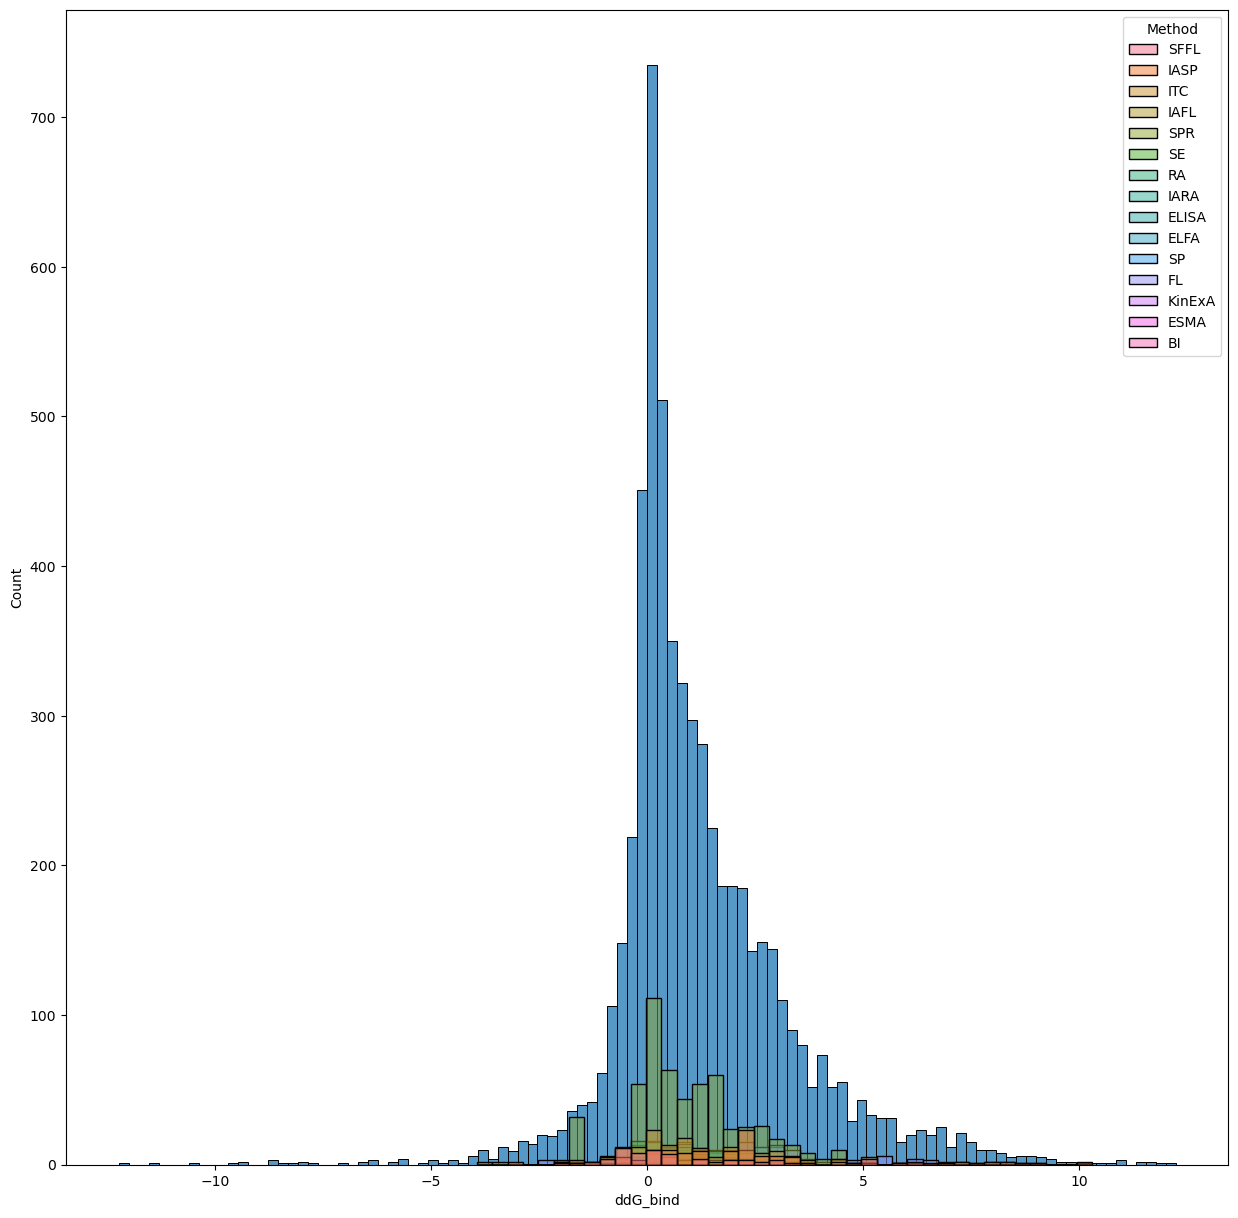

In [35]:
fig = plt.figure(figsize=(15, 15))
#sns.histplot(data=S4169_merged, x="ddG_bind_rev", hue="Method")
sns.histplot(x=skempi2_avg["ddG_bind"])
sns.histplot(x=skempi2_mm["ddG_bind_mean"],
             hue=skempi2_mm["Method"])

In [17]:
dif_chains = skempi2_avg[['PDB_ID', 'Chains']].groupby(['PDB_ID', 'Chains']).size().reset_index()
s = dif_chains.groupby(['PDB_ID']).size().reset_index()
s.loc[s[0]>1]
dif_chains.loc[dif_chains['PDB_ID'].isin(['2C5D', '3SE3', '3SE4'])]

,PDB_ID,Chains,0
145,2C5D,ABCD,19
146,2C5D,AC,16
262,3SE3,BA,47
263,3SE3,BC,2
264,3SE4,BA,18
265,3SE4,BC,17


In [18]:
# skempi2 = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi_v2.csv', sep=';')
# skempi2['PDB_ID'] = skempi2['#Pdb'].str.split('_').str[0]
# skempi2['index'] = skempi2.index.tolist()
# skempi2['case_ID'] = skempi2['index'].astype('str') + '_' + skempi2['PDB_ID']
#skempi2.to_csv('/groups/sbinlab/panf/SKEMPIv2/skempi2_mesure_mean.csv', index=False)

In [19]:
nick_pdbs = ['1JTG', '5E9D', '3SZK', '3BN9', '2J0T', '1KTZ', '3SGB', '3MZG', '1DAN', '1VFB', '1OGA']

In [20]:
skempi2.loc[(skempi2['#Pdb'].str.split("_").str[0].isin(nick_pdbs))&(skempi2['ddG_bind'].isna())]

,index,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),...,dS_mut (cal mol^(-1) K^(-1)),dS_wt (cal mol^(-1) K^(-1)),Notes,Method,SKEMPI version,PDB_ID,no_proper_value,dG_bind_WT,dG_bind_MUT,ddG_bind
362,362,1VFB_AB_C,YB101A,YB101A,COR,AB/AG,AB/AG,n.b,NaN,2E-08,...,NaN,NaN,NaN,SPR,2,1VFB,True,-10.498011,NaN,NaN
631,631,2J0T_A_D,"TD2R,VD4I","TD2R,VD4I","COR,RIM",NaN,2J0T_A_D,n.b,NaN,4E-10,...,NaN,NaN,NaN,IAFL,2,2J0T,True,-12.814660,NaN,NaN
2129,2129,1VFB_AB_C,YB101A,YB101A,COR,AB/AG,AB/AG,n.b,NaN,1.25E-08,...,NaN,NaN,NaN,SPR,2,1VFB,True,-10.776341,NaN,NaN


In [24]:
nick_pdbs_df = skempi2_avg.loc[skempi2_avg['PDB_ID'].isin(nick_pdbs)]

In [30]:
nick_pdbs_df['#Pdb'].unique()

array(['1VFB_AB_C', '2J0T_A_D', '1KTZ_A_B', '1JTG_A_B', '3BN9_B_CD',
       '3MZG_A_B', '1DAN_HL_UT', '3SGB_E_I', '1OGA_ABC_DE', '5E9D_AB_CDE',
       '3SZK_AB_C'], dtype=object)

In [21]:
# FOR FUTUTRE ANALYSIS: No binding detected, I would guess predictions should be >15 kcal/mol
# skempi2_filt.loc[skempi2_filt['Affinity_mut (M)']=='n.b']
# skempi2.loc[skempi2['Affinity_mut (M)'] == 'n.b', 'dG_bind_MUT'] = 100

In [ ]:
with open("file.txt", "w") as output:
    output.write(str(values))

In [58]:
skempi2['interaction_strength'].value_counts()

strong      2966
moderate    2888
weak        1225
None           2
Name: interaction_strength, dtype: int64

<AxesSubplot: xlabel='interaction_strength', ylabel='count'>

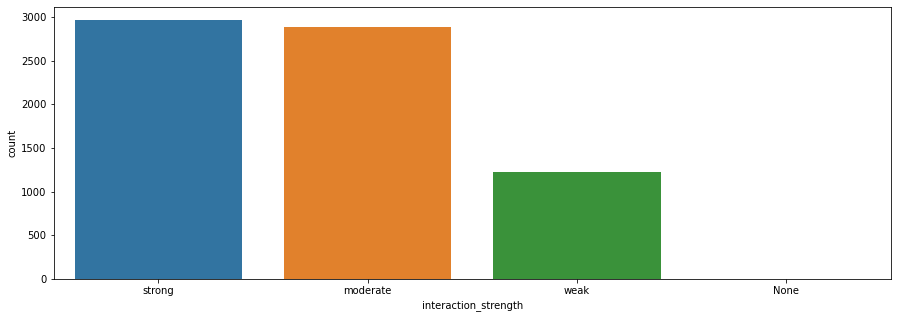

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=skempi2, x='interaction_strength', ax=ax)